# Phase 4: Causality Analysis (Granger & VAR)
**Goal:** Establish causal relationship between Fed sentiment and Economic Indicators (Inflation).

## Improved Methodology
1. **Time Series Preprocessing**: Handle non-stationarity and seasonality
2. **VAR Model**: Vector Autoregression for multivariate analysis
3. **Granger Causality**: Test for predictive causality
4. **Impulse Response**: Analyze shock propagation
5. **Variables**: Fed Sentiment vs CPI (Consumer Price Index) and PPI (Producer Price Index)

In [ ]:
# ! pip install statsmodels
# ! pip  install arch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [6]:
# Load Fed Sentiment Data
fed_sentiment = pd.read_csv('../data/result/monthly_index_FinBERT_FOMC.csv')
fed_sentiment['date'] = pd.to_datetime(fed_sentiment['month'])
fed_sentiment = fed_sentiment.set_index('date').sort_index()

# Load Economic Indicators (CPI/PPI)
econ_data = pd.read_csv('../data/raw/econ_indicators.csv')
econ_data['DATE'] = pd.to_datetime(econ_data['DATE'])
econ_data = econ_data.set_index('DATE').sort_index()

# We will use the Year-over-Year (YoY) changes as they are stationary-ish and what the Fed targets
econ_data = econ_data[['CPI_YoY', 'PPI_YoY']].dropna()

print(f"Fed sentiment data: {len(fed_sentiment)} observations")
print(f"Economic data: {len(econ_data)} observations")

Fed sentiment data: 74 observations
Economic data: 95 observations


Combined dataset shape: (74, 3)

First few rows:


,fed_sentiment,cpi_inflation,ppi_inflation
2018-01-01,0.380088,2.151319,3.775564
2018-02-01,0.792113,2.263469,4.018789
2018-03-01,-0.251021,2.330950,4.073107
2018-04-01,-0.240114,2.470996,3.782383
2018-05-01,0.077594,2.781922,5.394191


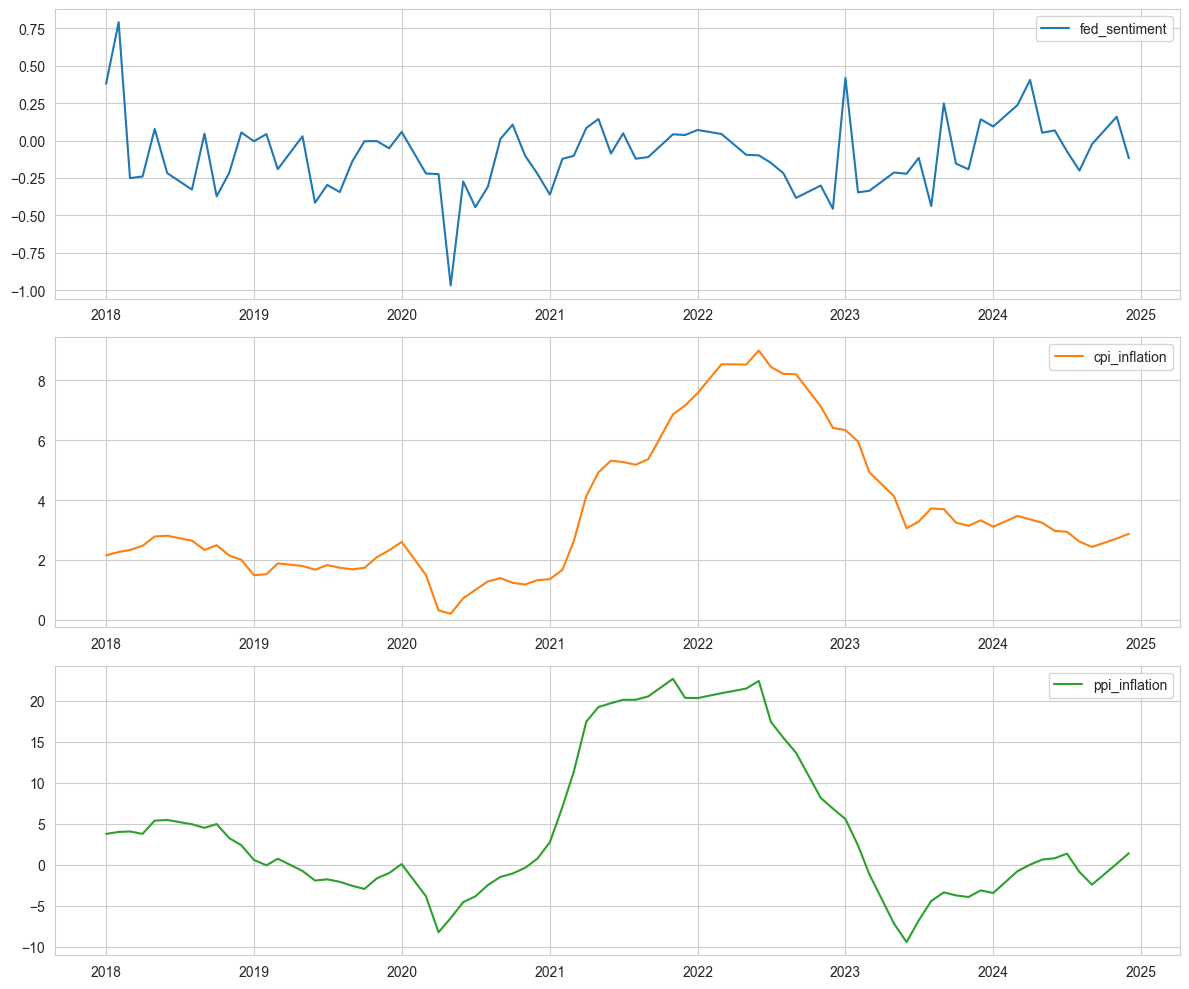

In [8]:
# Merge and resample to monthly (ensure alignment)
combined_data = pd.concat([
    fed_sentiment['sentiment_score'],
    econ_data
], axis=1).dropna()

# Rename columns for clarity
combined_data.columns = ['fed_sentiment', 'cpi_inflation', 'ppi_inflation']

print("Combined dataset shape:", combined_data.shape)
print("\nFirst few rows:")
display(combined_data.head())

# Plot the time series
fig, axes = plt.subplots(3, 1, figsize=(12, 10))
combined_data.plot(subplots=True, ax=axes)
plt.tight_layout()
plt.show()

In [9]:
# Stationarity Test Function
def test_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'\n{name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    
    if result[1] < 0.05:
        print("✓ Stationary")
        return True
    else:
        print("✗ Non-stationary")
        return False

# Test stationarity for all variables
stationary_results = {}
for col in combined_data.columns:
    stationary_results[col] = test_stationarity(combined_data[col], col)

# Difference non-stationary series
diff_data = combined_data.copy()
for col, is_stationary in stationary_results.items():
    if not is_stationary:
        diff_data[f'{col}_diff'] = combined_data[col].diff().dropna()
        print(f"\nDifferenced {col}")

print("\nFinal dataset shape (after differencing might vary):", diff_data.shape)


fed_sentiment Stationarity Test:
ADF Statistic: -5.8166
p-value: 0.0000
✓ Stationary

cpi_inflation Stationarity Test:
ADF Statistic: -1.6267
p-value: 0.4692
✗ Non-stationary

ppi_inflation Stationarity Test:
ADF Statistic: -2.6439
p-value: 0.0843
✗ Non-stationary

Differenced cpi_inflation

Differenced ppi_inflation

Final dataset shape (after differencing might vary): (74, 5)


In [10]:
# Select variables for VAR (prefer differenced if non-stationary)
var_variables = []
for col in ['fed_sentiment', 'cpi_inflation', 'ppi_inflation']:
    if stationary_results[col]:
        var_variables.append(col)
    else:
        var_variables.append(f'{col}_diff')

# Drop NA values from differencing
var_data = diff_data[var_variables].dropna()

print("Variables for VAR analysis:", var_variables)
print("VAR dataset shape:", var_data.shape)

# Determine optimal lag length
model = VAR(var_data)
lag_selection = model.select_order(maxlags=6) # Reduce maxlags if data is short
print("\nLag order selection:")
print(lag_selection.summary())

# Fit VAR model
optimal_lags = lag_selection.aic
# Limit lags if data is too short
if optimal_lags > 4 or optimal_lags == 0:
    optimal_lags = 2
    
var_model = model.fit(optimal_lags)
print(f"\nFitted VAR({optimal_lags}) model")
print(var_model.summary())

Variables for VAR analysis: ['fed_sentiment', 'cpi_inflation_diff', 'ppi_inflation_diff']
VAR dataset shape: (73, 3)

Lag order selection:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -3.785      -3.686     0.02271      -3.746
1     -4.267*     -3.872*    0.01403*     -4.111*
2      -4.157      -3.466     0.01569      -3.884
3      -4.013      -3.026     0.01820      -3.623
4      -3.828      -2.545     0.02207      -3.320
5      -4.097      -2.518     0.01709      -3.472
6      -4.164      -2.288     0.01631      -3.422
-------------------------------------------------

Fitted VAR(1) model
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Dec, 2025
Time:                     13:18:57
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:     

In [11]:
# Granger Causality Tests
def granger_test(data, x, y, max_lags=4):
    print(f"\n=== Granger Causality: {x} → {y} ===")
    try:
        test_result = grangercausalitytests(data[[y, x]], max_lags, verbose=False)
        
        # Get F-test p-values for different lags
        p_values = []
        for lag in range(1, max_lags+1):
            f_test = test_result[lag][0]['ssr_ftest']
            p_values.append(f_test[1])
        
        min_p = min(p_values)
        best_lag = p_values.index(min_p) + 1
        
        print(f"Minimum p-value: {min_p:.4f} (at lag {best_lag})")
        
        if min_p < 0.05:
            print(f"✓ {x} Granger-causes {y} (significant at 5% level)")
        else:
            print(f"✗ No Granger causality from {x} to {y}")
        
        return min_p, best_lag
    
    except Exception as e:
        print(f"Error in Granger test: {e}")
        return None, None

# Test causality
causality_results = []
# Check if Sentiment -> Inflation
targets = [v for v in var_variables if 'cpi' in v or 'ppi' in v]
source = [v for v in var_variables if 'sentiment' in v][0]

for target in targets:
    p_val, lag = granger_test(var_data, source, target)
    if p_val is not None:
        causality_results.append({
            'source': source,
            'target': target,
            'p_value': p_val,
            'optimal_lag': lag,
            'significant': p_val < 0.05
        })

# Display results
results_df = pd.DataFrame(causality_results)
print("\n=== Summary of Granger Causality Tests ===")
display(results_df)


=== Granger Causality: fed_sentiment → cpi_inflation_diff ===
Minimum p-value: 0.5786 (at lag 1)
✗ No Granger causality from fed_sentiment to cpi_inflation_diff

=== Granger Causality: fed_sentiment → ppi_inflation_diff ===
Minimum p-value: 0.5641 (at lag 1)
✗ No Granger causality from fed_sentiment to ppi_inflation_diff

=== Summary of Granger Causality Tests ===


,source,target,p_value,optimal_lag,significant
0,fed_sentiment,cpi_inflation_diff,0.578583,1,False
1,fed_sentiment,ppi_inflation_diff,0.564072,1,False


In [12]:
# Impulse Response Analysis
def plot_irf(var_model, impulse, response, periods=12):
    irf = var_model.irf(periods)
    
    # Find column indices
    impulse_idx = var_model.names.index(impulse)
    response_idx = var_model.names.index(response)
    
    # Plot impulse response
    plt.figure(figsize=(10, 6))
    irf.plot(impulse=impulse_idx, response=response_idx, 
             orth=True,  # Orthogonalized IRF
             plot_stderr=True)
    plt.title(f'Impulse Response: {impulse} → {response}')
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot IRFs for significant relationships
for result in causality_results:
    if result['significant']:
        impulse = result['source']
        response = result['target']
        print(f"\nPlotting IRF: {impulse} → {response}")
        plot_irf(var_model, impulse, response)